# 1. Import the necessery libraries


In [1]:
!sudo nvidia-smi

Wed Nov 19 22:40:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 4000                Off |   00000000:18:00.0 Off |                  N/A |
| 30%   41C    P8              9W /  125W |    4917MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# If you want to use the spesific GPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # use GPU 1 or GPU 0

import tensorflow as tf

# List GPUs available
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

# Check if GPUs are available
if gpus:
    print("GPU is available.")
else:
    print("GPU is not available.")

# Set memory growth for each GPU
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2025-11-19 22:40:57.610547: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 22:40:57.665423: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-19 22:40:58.960656: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
GPU is available.


In [3]:
import numpy as np
import os
import pandas as pd 
import imageio 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras import regularizers

# 2. Load and split the data 

In [4]:
image_dir = "./data_set/images/"  
mask_dir  = "./data_set/masks/" 

image_filenames = sorted([
    f for f in os.listdir(image_dir)
    if not f.startswith(".") and f.lower().endswith(".jpg")
])

mask_filenames = sorted([
    f for f in os.listdir(mask_dir)
    if not f.startswith(".") and f.lower().endswith(".png")
])

# Check that images and masks match correctly
for img, msk in zip(image_filenames, mask_filenames):
    if img.split('.')[0] != msk.split('.')[0]:
        print("❌ Mismatch:", img, msk)

image_list = [os.path.join(image_dir, f) for f in image_filenames]
mask_list  = [os.path.join(mask_dir,  f) for f in mask_filenames]

# Make the train/validation split dynamic
train_image_list, validation_image_list, train_mask_list, validation_mask_list = \
train_test_split(image_list, mask_list, test_size=0.2, random_state=42)

print("Total images:", len(image_list))
print("image_list:", train_image_list)

print("Total masks:", len(mask_list))
print("mask_list:", train_mask_list)

unique_values = np.unique(imageio.v2.imread(mask_list[0]))
print("Mask classes:", unique_values)

Total images: 8
image_list: ['./data_set/images/post-harvest_01.jpg', './data_set/images/post-harvest_03_3.jpg', './data_set/images/post-harvest_01_3.jpg', './data_set/images/post-harvest_02_2.jpg', './data_set/images/post-harvest_02.jpg', './data_set/images/post-harvest_03_2.jpg']
Total masks: 8
mask_list: ['./data_set/masks/post-harvest_01.png', './data_set/masks/post-harvest_03_3.png', './data_set/masks/post-harvest_01_3.png', './data_set/masks/post-harvest_02_2.png', './data_set/masks/post-harvest_02.png', './data_set/masks/post-harvest_03_2.png']
Mask classes: [0 1 2 3]


# 3. explore some images :

In [5]:
def load_and_plot_image_mask(img_path, mask_path):
    """
    Loads an image and mask, keeps original size, prints shapes, and plots:
        1. Original image
        2. Original mask in color
        3. Overlay of mask on the image

    Args:
        img_path (str): Path to the image file
        mask_path (str): Path to the mask file

    Returns:
        img (tf.Tensor): Normalized image tensor (0-1)
        mask (tf.Tensor): Integer mask tensor
    """
    
    # Define colors for mask classes: background, good, fair, poor
    class_colors = np.array([
        [0, 0, 0],        # 0 = background (black)
        [0, 255, 0],      # 1 = good (green)
        [255, 255, 0],    # 2 = fair (yellow)
        [255, 0, 0]       # 3 = poor (red)
    ], dtype=np.uint8)
    
    # Load image
    img = imageio.imread(img_path)
    img = tf.cast(img, tf.float32) / 255.0  # normalize to 0-1
    
    # Load mask
    mask = imageio.imread(mask_path)
    mask = tf.cast(mask[..., np.newaxis], tf.uint8)[...,0].numpy()  # keep integers
    
    # Print shapes
    print("Image shape:", img.shape)
    print("Mask shape:", mask.shape)
    
    # Convert mask to color
    mask_color = class_colors[mask]
    
    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    
    # Original image
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].axis('on')
    
    # Original mask in color
    ax[1].imshow(mask_color)
    ax[1].set_title("Original Mask (Color)")
    ax[1].axis('on')
    
    # Overlay
    overlay = (0.6 * img.numpy() + 0.4 * mask_color / 255.0)
    ax[2].imshow(overlay)
    ax[2].set_title("Overlay")
    ax[2].axis('on')
    
    plt.show()
    
    # Print unique mask values for sanity check
    print("Unique mask values:", np.unique(mask))
    
    return img, mask


/tmp/ipykernel_1632877/2670707206.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
I0000 00:00:1763592061.335691 1632877 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1723 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:18:00.0, compute capability: 7.5
I0000 00:00:1763592061.337360 1632877 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 204 MB memory:  -> device: 1, name: Quadro RTX 4000, pci bus id: 0000:3b:00.0, compute capability: 7.5
/tmp/ipykernel_1632877/2670707206.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `im

Image shape: (312, 312, 3)
Mask shape: (312, 312)


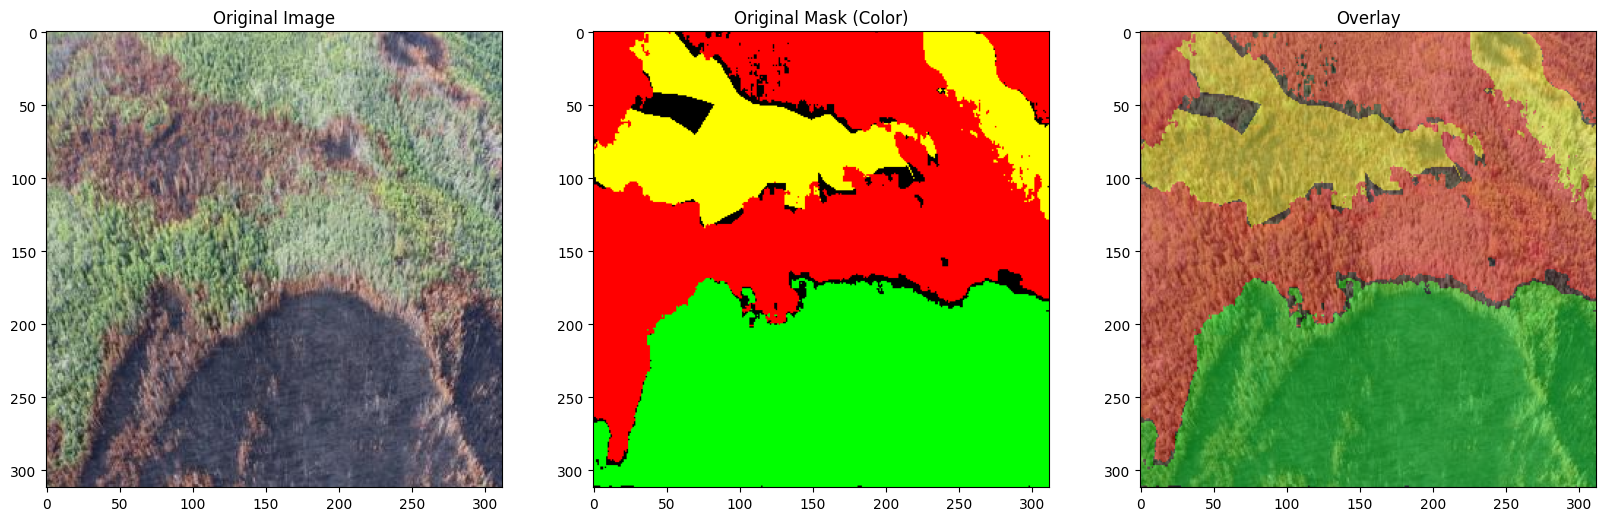

Unique mask values: [0 1 2 3]


In [6]:
n = 1
img, mask = load_and_plot_image_mask(train_image_list[n], train_mask_list[n])


In [7]:
train_images = tf.constant(train_image_list)
train_masks = tf.constant(train_mask_list)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_masks))
for image,mask in train_dataset.take(1) : 
    print(image)
    print(mask)
    
validation_images = tf.constant(validation_image_list)
validation_masks = tf.constant(validation_mask_list)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images,validation_masks))
for image,mask in validation_dataset.take(1) : 
    print(image)
    print(mask)    

tf.Tensor(b'./data_set/images/post-harvest_01.jpg', shape=(), dtype=string)
tf.Tensor(b'./data_set/masks/post-harvest_01.png', shape=(), dtype=string)
tf.Tensor(b'./data_set/images/post-harvest_01_2.jpg', shape=(), dtype=string)
tf.Tensor(b'./data_set/masks/post-harvest_01_2.png', shape=(), dtype=string)


2025-11-19 22:41:01.887459: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-19 22:41:01.903698: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# 4. preprocessing our data

In [8]:
def process_path(image_path,mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.convert_image_dtype(img,tf.float32) #this do the same as dividing by 255 to set the values between 0 and 1 (normalization)    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask,channels=3)
    mask = tf.math.reduce_max(mask,axis=-1,keepdims=True)
    return img , mask

def preprocess(image,mask) : 
    input_image = tf.image.resize(image,(96,128),method='nearest') # consider keeping higher resolution (e.g., 256×256) if GPU memory allows.
    input_mask = tf.image.resize(mask,(96,128),method='nearest')    
    return input_image , input_mask

train_image_ds = train_dataset.map(process_path) # apply the preprocces_path function to our train_dataset
print(train_image_ds)
train_processed_image_ds = train_image_ds.map(preprocess) # apply the preprocess function to our train_dataset

validation_image_ds = validation_dataset.map(process_path) # apply the preprocces_path function to our validation_dataset
print(validation_image_ds)
validation_processed_image_ds = validation_image_ds.map(preprocess) 


<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>


In [9]:
# Add data augmentation (flips, rotations)
# def augment(image, mask):
#     if tf.random.uniform(()) > 0.5:
#         image = tf.image.flip_left_right(image)
#         mask = tf.image.flip_left_right(mask)
#     return image, mask
# train_processed_image_ds = train_processed_image_ds.map(augment)

# 5.  Define The Conv Block For The Contracting Path


In [10]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
   
    

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

# 6. Define the upsampling block for the expanding path

In [11]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
        
    return conv

# 7. Finally! ,  we will Define the unet model 
## which composes of a set of conv blocks and upsampling blocks

In [12]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=4):
    
    inputs = Input(input_size)
    
    # contracting path
    cblock1 = conv_block(inputs, n_filters, dropout_prob=0.4)
    cblock2 = conv_block(cblock1[0], 2*n_filters, dropout_prob=0.4)
    cblock3 = conv_block(cblock2[0], 4*n_filters, dropout_prob=0.4)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.45) 
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.4, max_pooling=None)     
    
    # expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, kernel_size=1, activation='softmax', padding='same')(conv9)
    # conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [13]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

# 8. Our model is ready !!

In [14]:
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 128,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 128,   │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 96, 128,   │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 96, 128,   │          0 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 64,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 48, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 48, 64,    │          0 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 32,    │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 24, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 24, 32,    │          0 │ conv2d_5[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 16,    │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 12, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 12, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 8, 256) │          0 │ dropout_3[0][0] 

 Total params: 8,639,844 (32.96 MB)

 Trainable params: 8,639,844 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
EPOCHS = 500
BUFFER_SIZE = 390
BATCH_SIZE = 2

# train
# train_processed_image_ds.batch(BATCH_SIZE)
train_dataset = train_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_processed_image_ds.element_spec)

# validation
# validation_processed_image_ds.batch(BATCH_SIZE)
# validation_dataset = validation_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_processed_image_ds.cache().batch(BATCH_SIZE)

print(validation_processed_image_ds.element_spec)
 

model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7545 - loss: 0.6038 
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7501 - loss: 0.5956
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7489 - loss: 0.5900
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7602 - loss: 0.5756
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7324 - loss: 0.6183
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7549 - loss: 0.5724
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7510 - loss: 0.5805
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7709 - loss: 0.5603
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7603 - loss: 0.5628
E

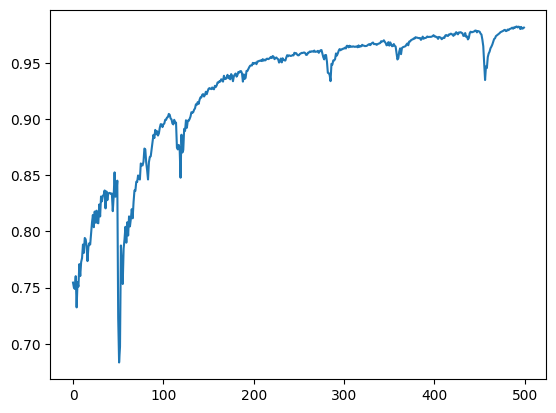

In [22]:
plt.plot(model_history.history["accuracy"])

In [23]:
CLASS_COLORS = np.array([
    [0, 0, 0],        # background = black
    [0, 255, 0],      # good = green
    [255, 255, 0],    # fair = yellow
    [255, 0, 0]       # poor = red
], dtype=np.uint8)

def mask_to_color(mask):
    """
    Convert integer mask (0,1,2,3) to RGB color mask
    """
    mask = mask.numpy() if tf.is_tensor(mask) else mask  # convert TF tensor to NumPy
    color_mask = CLASS_COLORS[mask.astype(np.int32)]
    return color_mask

def display(display_list):
    """
    display_list = [input_image, true_mask, predicted_mask]
    """
    plt.figure(figsize=(15, 15))
    titles = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.axis('off')
        plt.title(titles[i])

        if i == 1 or i == 2:  # True mask or predicted mask
            mask = display_list[i]
            if mask.shape[-1] == 1:  # single channel
                mask = mask[..., 0]
            color_mask = mask_to_color(mask)
            plt.imshow(color_mask)
        else:
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))

    plt.show()

def create_mask(pred_mask):
    """
    Converts UNet softmax output to integer mask (0,1,2,3)
    """
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0].numpy().astype(np.uint8)

def show_predictions(dataset=None, num=1):
    """
    Displays predictions for the first 'num' batches of a dataset
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        pred_mask = unet.predict(sample_image[tf.newaxis, ...])
        display([sample_image, sample_mask, create_mask(pred_mask)])

----- training_dataset results---------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


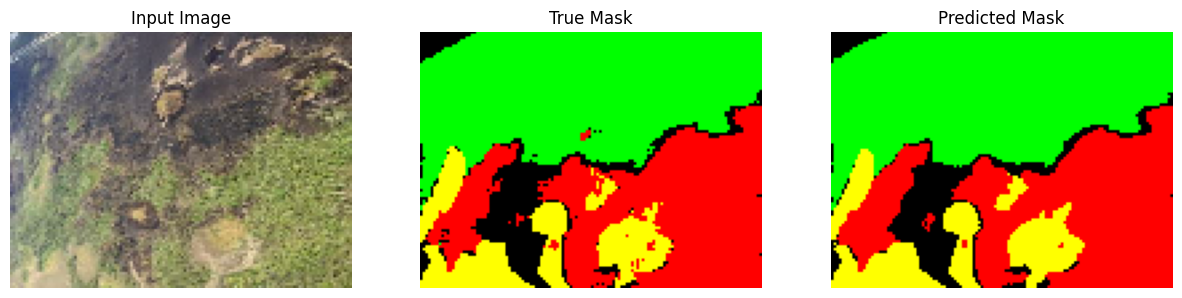

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


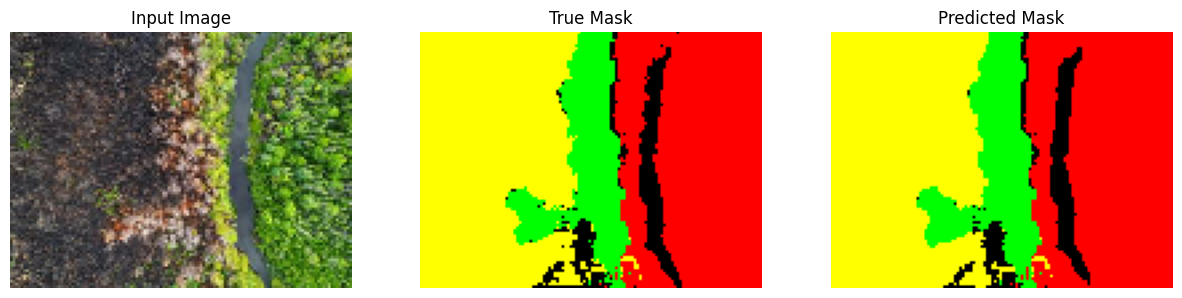

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


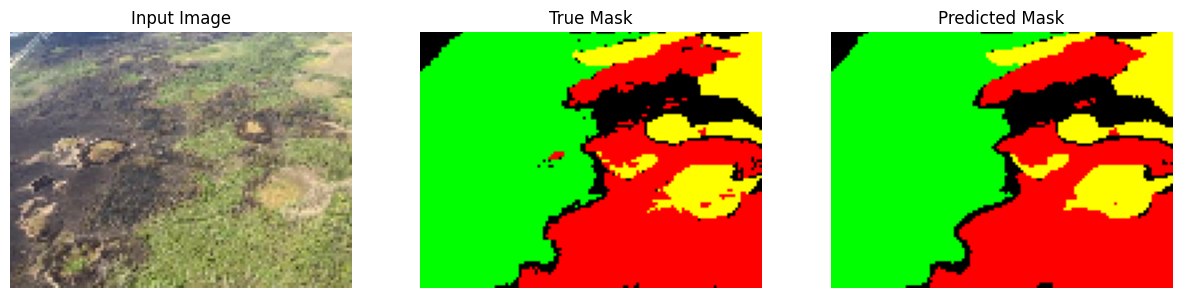

----- validation_dataset results---------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


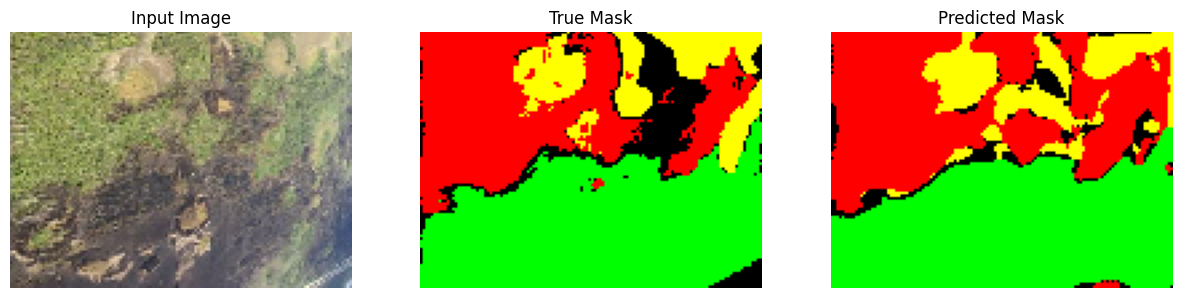

In [24]:
print("----- training_dataset results---------")
show_predictions(train_dataset, 6)
print("----- validation_dataset results---------")
show_predictions(validation_dataset, 6)

In [25]:
# model evaluation
print("Unet Model Evaluation: ")
unet.evaluate(validation_dataset)

Unet Model Evaluation: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8974 - loss: 0.4327


[0.4326738715171814, 0.8973795771598816]